In [51]:
import numpy as np
from typing import Literal
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from numpy.typing import NDArray
from sklearn.cluster import KMeans
from abc import ABC, abstractmethod
from scipy.linalg import cholesky, inv
from sklearn.metrics import davies_bouldin_score


In [ ]:
class Scaler(ABC):
    @abstractmethod
    def normalize(self, X: NDArray, update_params: bool = False) -> NDArray:
        pass

    @abstractmethod
    def denormalize(self, X: NDArray) -> NDArray:
        pass

class MinMaxScaler(Scaler):
    def __init__(self):
        self.min = None
        self.max = None
        pass

    def normalize(self, X: NDArray, update_params: bool = False):
        min = np.min(X, axis=0) if self.min is None or update_params else self.min
        max = np.max(X, axis=0) if self.max is None or update_params else self.max

        self.min = min
        self.max = max

        return (X - min) / (max - min)

    def denormalize(self, X: NDArray):
        return X * (self.max - self.min) + self.min


In [ ]:
class KMeansTrainer:
    def __init__(self, dataset: NDArray, k: int, distance: Literal['euclidean', 'mahalanobis'] = 'euclidean'):
        self.dataset = dataset
        self.k = k
        self.distance = distance
        self._mahalanobis_transform_matrix: NDArray = None
        self.best_model: KMeans = None
        self.best_error: float = float('inf')

    def fit(self, n_runs: int):
        data_to_cluster = self._preprocess_input(self.distance)
        self.best_error = float('inf')

        for _ in range(n_runs):
            model = KMeans(n_clusters=self.k, n_init=1)
            model.fit(data_to_cluster)

            if model.inertia_ < self.best_error:
                self.best_error = model.inertia_
                self.best_model = model

    def get_centroids(self) -> NDArray:
        centroids = self.best_model.cluster_centers_

        if self.distance == 'euclidean':
            return centroids

        if self.distance == 'mahalanobis':
            inv_transform_matrix = inv(self._mahalanobis_transform_matrix)
            return centroids @ inv_transform_matrix

    def _preprocess_input(self, distance: Literal['euclidean', 'mahalanobis']) -> NDArray:
        self.distance = distance
        if distance == 'euclidean':
            return self.dataset

        if distance == 'mahalanobis':
            if self._mahalanobis_transform_matrix is None:
                cov = np.cov(self.dataset, rowvar=False)
                cov_reg = cov + np.eye(cov.shape[0]) * 1e-6
                inv_cov = np.linalg.inv(cov_reg)
                self._mahalanobis_transform_matrix = cholesky(inv_cov, lower=True)

            return self.dataset @ self._mahalanobis_transform_matrix


In [ ]:
def train_k_range(dataset: NDArray, k_range: range, n_runs: int, distance: Literal['euclidean', 'mahalanobis']):
    db_scores_per_k = []
    models: list[KMeansTrainer] = []

    for k in k_range:
        trainer = KMeansTrainer(dataset=dataset, k=k, distance=distance)
        trainer.fit(n_runs=n_runs)
        db_score = davies_bouldin_score(dataset, trainer.best_model.labels_)
        db_scores_per_k.append(db_score)
        models.append(trainer)
        print(f'K={k}, Índice DB={db_score:.3f}')

    return models, db_scores_per_k


In [55]:
def plot_clusters(dataset: NDArray, model: KMeansTrainer, title: str):
    labels = model.best_model.labels_
    centroids = model.get_centroids()

    k = len(np.unique(labels))
    colors = cm.viridis(np.linspace(0, 1, k))

    plt.figure(figsize=(12, 8))

    for i in range(k):
        cluster_points = dataset[labels == i]
        plt.scatter(
            cluster_points[:, 0],
            cluster_points[:, 1],
            s=50,
            c=[colors[i]],
            marker='o',
            alpha=0.7,
            label=f'Grupo {i+1}'
        )

    plt.scatter(
        centroids[:, 0],
        centroids[:, 1],
        s=250,
        marker='x',
        c='red',
        linewidths=3,
        label='Centroides'
    )

    plt.title(title)
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.grid(True)
    plt.show()


def plot_errors(k_values: list, errors: list, title: str):
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, errors, 'bo-', markersize=8, linewidth=2)
    plt.xlabel('K')
    plt.ylabel('Índice DB')
    plt.title(title)
    plt.grid(True)
    plt.xticks(k_values)
    plt.show()


# Questão 01 -> items a,b

1. Carregando dataset e normalizando os dados
2. Definindo os parâmetros para o K-médias (K de 4 à 20, para cada K rodar 20 vezes, distâncias euclidiana e de mahalanobis)
3. Plotando o índice DB para o melhor modelo de cada K encontrado
4. Plotando os grupos para o melhor valor de K encontrado (com menor índice DB)


Treinamento com a distância: euclidean
K=4, Índice DB=0.725
K=5, Índice DB=0.634
K=6, Índice DB=0.639
K=7, Índice DB=0.618
K=8, Índice DB=0.682
K=9, Índice DB=0.660
K=10, Índice DB=0.619
K=11, Índice DB=0.598
K=12, Índice DB=0.662
K=13, Índice DB=0.590
K=14, Índice DB=0.649
K=15, Índice DB=0.634
K=16, Índice DB=0.660
K=17, Índice DB=0.600
K=18, Índice DB=0.654
K=19, Índice DB=0.614
K=20, Índice DB=0.614


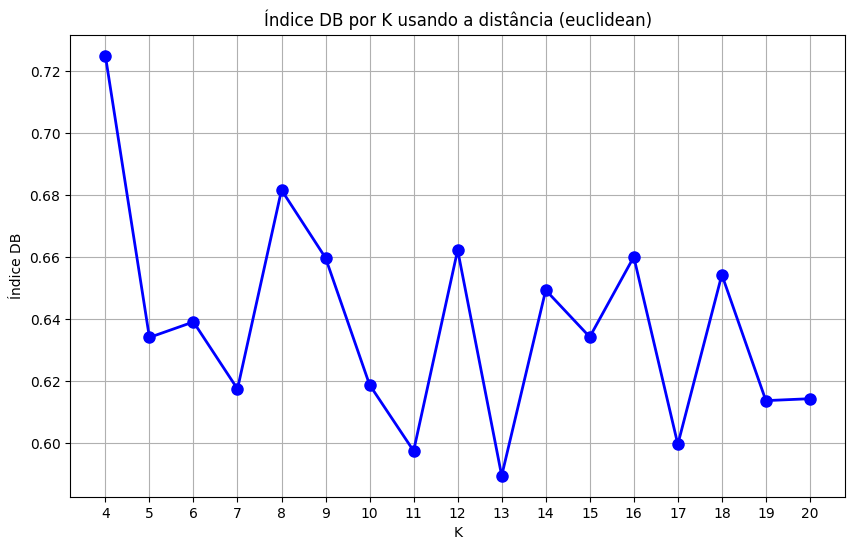

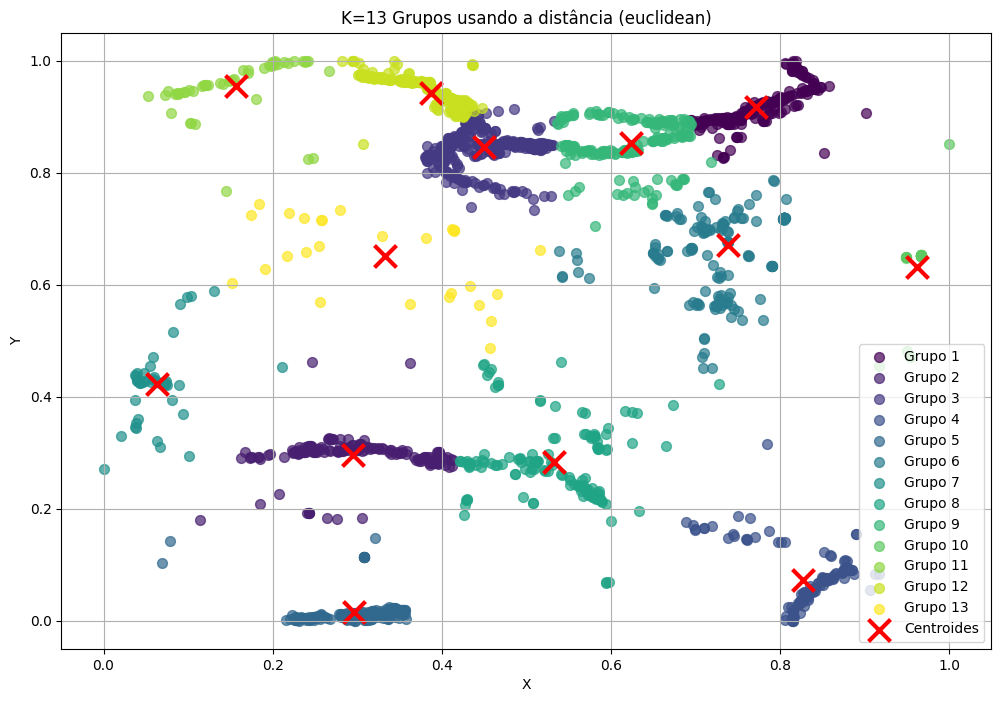

Treinamento com a distância: mahalanobis
K=4, Índice DB=0.714
K=5, Índice DB=0.747
K=6, Índice DB=0.716
K=7, Índice DB=0.680
K=8, Índice DB=0.691
K=9, Índice DB=0.672
K=10, Índice DB=0.634
K=11, Índice DB=0.652
K=12, Índice DB=0.632
K=13, Índice DB=0.635
K=14, Índice DB=0.688
K=15, Índice DB=0.702
K=16, Índice DB=0.700
K=17, Índice DB=0.693
K=18, Índice DB=0.657
K=19, Índice DB=0.652
K=20, Índice DB=0.658


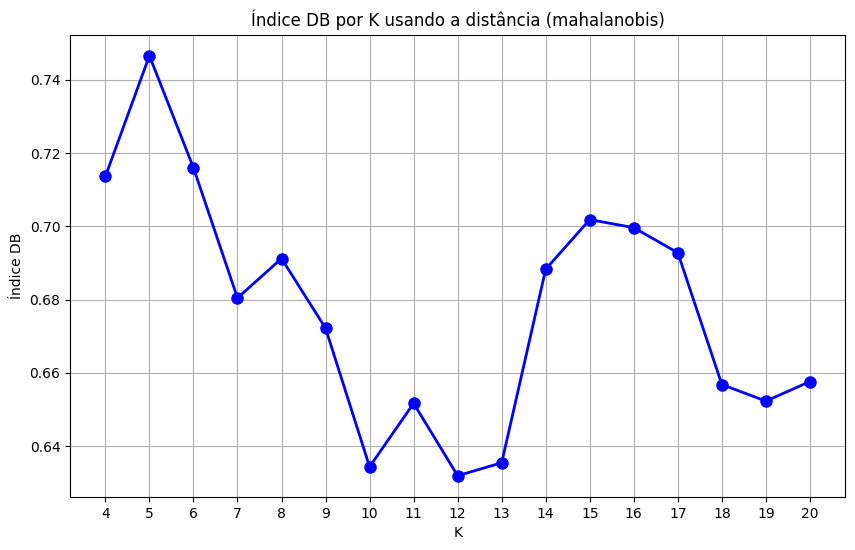

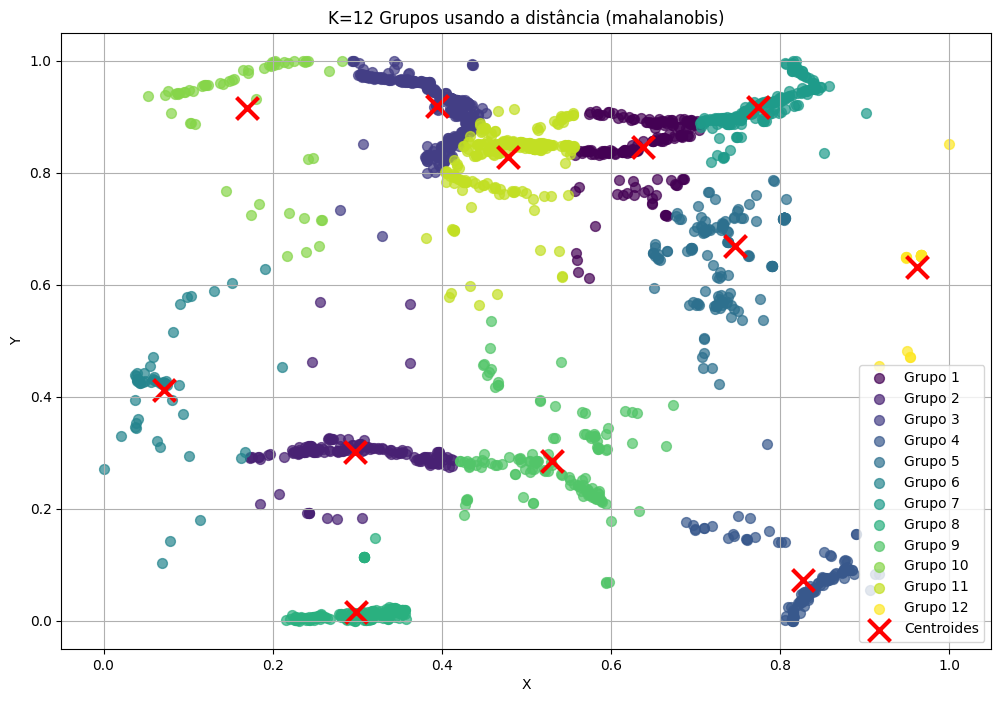

In [56]:
dataset = np.genfromtxt('quake.csv', delimiter=',')
scaler = MinMaxScaler()
dataset = scaler.normalize(dataset, update_params=True)

k_range = range(4, 21)
n_runs = 20
distances = ['euclidean', 'mahalanobis']

for distance in distances:
    print(f'Treinamento com a distância: {distance}')
    models, errors = train_k_range(dataset, k_range, n_runs, distance=distance)
    plot_errors(list(k_range), errors, f'Índice DB por K usando a distância ({distance})')

    best_k = np.argmin(errors)
    best_model = models[best_k]

    plot_clusters(dataset, best_model, f'K={best_k + 4} Grupos usando a distância ({distance})')
